# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

keywords are unexpanded, not using


In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.997634,True,7.226835
1,0.488097,True,5.499293
2,0.035778,True,6.486450
3,-0.930496,False,-2.686775
4,-0.336418,False,-1.882169
...,...,...,...
995,-0.332407,True,3.751964
996,0.525514,True,6.117159
997,0.162795,False,0.842025
998,-0.661884,False,-0.783397


<AxesSubplot:xlabel='v0'>

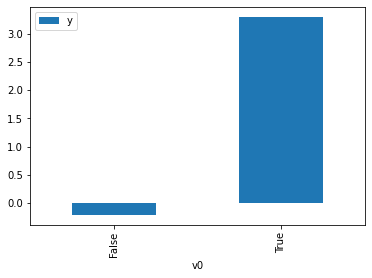

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot:xlabel='v0'>

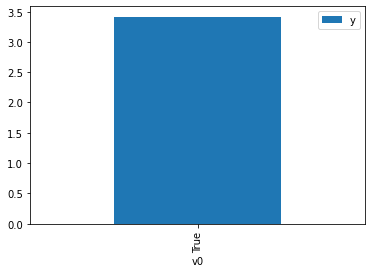

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,-0.515472,False,-0.121133,0.739834,1.351654
1,-0.815367,False,-1.363175,0.844038,1.184781
2,-0.945070,False,-2.925555,0.877276,1.139892
3,-0.200988,False,-0.473581,0.591537,1.690510
4,0.137545,False,-0.058853,0.411914,2.427690
...,...,...,...,...,...
995,1.832505,False,6.536063,0.018112,55.211738
996,-0.612588,False,0.095564,0.777903,1.285508
997,-0.911785,False,-2.120072,0.869378,1.150248
998,-0.738034,False,-0.528922,0.820929,1.218132


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,-0.392759,True,1.868258,0.313931,3.185414
1,0.122415,True,5.189023,0.580200,1.723545
2,-1.527900,True,2.397001,0.038514,25.964427
3,-0.490316,True,3.251679,0.270689,3.694278
4,-2.726651,True,0.345228,0.003050,327.878354
...,...,...,...,...,...
995,-2.201035,True,-0.266864,0.009361,106.824754
996,-0.835462,True,3.410684,0.150370,6.650271
997,-2.201035,True,-0.266864,0.009361,106.824754
998,0.369715,True,6.630242,0.701452,1.425615


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.952
Model:                            OLS   Adj. R-squared (uncentered):              0.952
Method:                 Least Squares   F-statistic:                              9877.
Date:                Thu, 21 Jul 2022   Prob (F-statistic):                        0.00
Time:                        08:02:09   Log-Likelihood:                         -1427.2
No. Observations:                1000   AIC:                                      2858.
Df Residuals:                     998   BIC:                                      2868.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.0106      0.032     63.112      0.000       1.948       2.073
x2             4.9501      0.051     97.958      0.000       4.851       5.049
==============================================================================
Omnibus:                        0.336   Durbin-Watson:                   2.027
Prob(Omnibus):                  0.845   Jarque-Bera (JB):                0.379
Skew:                          -0.043   Prob(JB):                        0.828
Kurtosis:                       2.957   Cond. No.                         1.79
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""